In [1]:
!kaggle datasets download -d moazeldsokyx/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/moazeldsokyx/dogs-vs-cats
License(s): CC0-1.0
100%|█████████████████████████████████████████| 817M/817M [00:07<00:00, 165MB/s]
100%|█████████████████████████████████████████| 817M/817M [00:07<00:00, 114MB/s]


In [1]:
# ! unzip /teamspace/studios/this_studio/dogs-vs-cats.zip

## install and load

In [ ]:
# install
!pip install pytorch-lightning --quiet
!pip install torchmetrics --quiet
!pip install torchsummary --quiet
!pip install visualtorch --quiet

In [1]:
# load
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import OneCycleLR


from torchvision import transforms
from torchvision.datasets import ImageFolder

from torchsummary import summary

import torchmetrics

import visualtorch
from collections import defaultdict

from PIL import Image

## pre

In [2]:
# data path
data_dir = '/teamspace/studios/this_studio/dataset'
test_path = data_dir + '/test'
train_path = data_dir + '/train'
val_path = data_dir + '/validation'

# dataset class
os.listdir(train_path)

['cats', 'dogs']

In [3]:
# dataset class len
print(f'normal : {len(os.listdir(train_path + "/cats"))}')
print(f'pnemo : {len(os.listdir(train_path + "/dogs"))}')

print(f'normal : {len(os.listdir(val_path + "/cats"))}')
print(f'pnemo : {len(os.listdir(val_path + "/dogs"))}')

print(f'normal : {len(os.listdir(test_path + "/cats"))}')
print(f'pnemo : {len(os.listdir(test_path + "/dogs"))}')



normal : 10000
pnemo : 10000
normal : 2500
pnemo : 2500
normal : 6242
pnemo : 6219


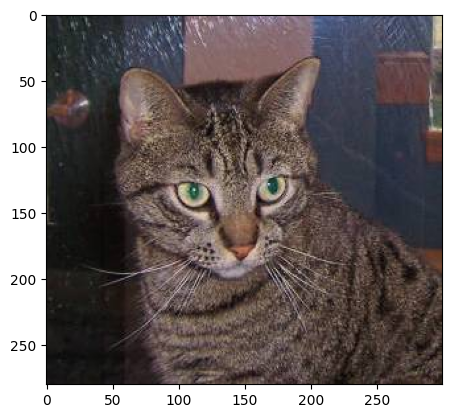

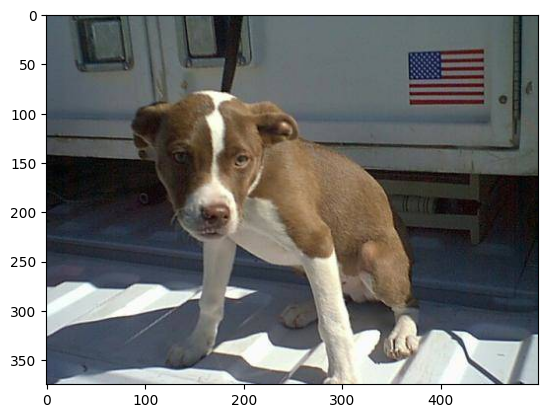

In [8]:
img1 = cv2.imread(train_path + '/cats/cat.1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

img2 = cv2.imread(train_path + '/dogs/dog.10027.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

In [14]:
img1.shape, img2.shape

((280, 300, 3), (375, 499, 3))

In [3]:
# create transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# train , test
train_dataset = ImageFolder(train_path, transform=train_transforms)
val_dataset = ImageFolder(val_path, transform=val_transforms)
test_dataset = ImageFolder(test_path, transform=val_transforms)

## plain network

In [7]:
class PlainBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity=None, stride=1):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels*4,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels*4)
        )

        # self.identity = identity
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        # identity_1 = x.clone()

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # if self.identity is not None:
        #     identity_1 = self.identity(identity_1)

        # x += identity_1
        x = self.relu(x)
        return x

In [18]:
class PlainNetwork(pl.LightningModule):
    def __init__(self, learning_rate, batch_size, block, layers):
        super().__init__()

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.accuracy = torchmetrics.Accuracy(task='binary', num_classes=2)
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(0.2)
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
          )

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*4, 2)



    def _make_layer(self, block, num_blocks, out_channels, stride):
        identity = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*4:
          identity = nn.Sequential(
              nn.Conv2d(
                  in_channels=self.in_channels,
                  out_channels=out_channels*4,
                  kernel_size=1,
                  stride=stride,
                  bias=False
              ),
              nn.BatchNorm2d(out_channels*4)
          )

        layers.append(block(self.in_channels, out_channels, identity, stride))
        self.in_channels = out_channels*4

        for i in range(num_blocks - 1):
          layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        return test_loader



    def forward(self, x):
      x = self.conv1(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = nn.Flatten()(x)
      x = self.fc(x)
      return x


    def _common_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.accuracy(preds, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'train_loss': loss, 'train_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'val_loss': loss, 'val_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'test_loss': loss, 'test_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss


    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        return logits


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        return optimizer

In [19]:
device = torch.device('cuda')

plainModel = PlainNetwork(
    learning_rate=0.01,
    batch_size=32,
    block=PlainBlock,
    layers=[3, 4, 6, 3]
).to(device)

In [15]:
summary(plainModel, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
             ReLU-13        [-1, 256, 112, 112]               0
       PlainBlock-14        [-1, 256, 1

In [20]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=4
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(plainModel)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type              | Params | Mode 
-----------------------------------------------------------------
0 | accuracy           | BinaryAccuracy    | 0      | train
1 | cross_entropy_loss | CrossEntropyLoss  | 0      | train
2 | dropout            | Dropout           | 0      | train
3 | conv1              | Sequential        | 9.6 K  | train
4 | layer1             | Sequential        | 198 K  | train
5 | layer2             | Sequential        | 1.1 M  | train
6 | layer3             | Sequential        | 6.6 M  | train
7 | layer4             | Sequential        | 12.9 M | train
8 | avgpool            | AdaptiveAvgPool2d | 0      | train
9 | fc                 | Linear            | 4.1 K  | train
-----------------------------------------------------------------
20.7 M    Trainable params
0         Non-trainable params
20.7 M    Total params
82.942    Total estimated model params size (MB)
222       Modules in train mode
0  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [22]:
trainer.validate()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /teamspace/studios/this_studio/lightning_logs/version_15/checkpoints/epoch=3-step=2500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/lightning_logs/version_15/checkpoints/epoch=3-step=2500.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5040000081062317     │
│         val_loss          │    1.1500873565673828     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.1500873565673828, 'val_acc': 0.5040000081062317}]

In [23]:
trainer.test()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /teamspace/studios/this_studio/lightning_logs/version_15/checkpoints/epoch=3-step=2500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/lightning_logs/version_15/checkpoints/epoch=3-step=2500.ckpt
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5113554000854492     │
│         test_loss         │    1.1536668539047241     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1536668539047241, 'test_acc': 0.5113554000854492}]

## residual network

In [5]:
# residualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity=None, stride=1):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels*4,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels*4)
        )

        self.identity = identity
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        identity_1 = x.clone()

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        if self.identity is not None:
            identity_1 = self.identity(identity_1)

        x += identity_1
        x = self.relu(x)
        return x

In [6]:
# residual network with pytorch lightning

class ResidualNetwork(pl.LightningModule):
    def __init__(self, learning_rate, batch_size, block, layers):
        super().__init__()

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.accuracy = torchmetrics.Accuracy(task='binary', num_classes=2)
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(0.2)
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
          )

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*4, 2)



    def _make_layer(self, block, num_blocks, out_channels, stride):
        identity = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*4:
          identity = nn.Sequential(
              nn.Conv2d(
                  in_channels=self.in_channels,
                  out_channels=out_channels*4,
                  kernel_size=1,
                  stride=stride,
                  bias=False
              ),
              nn.BatchNorm2d(out_channels*4)
          )

        layers.append(block(self.in_channels, out_channels, identity, stride))
        self.in_channels = out_channels*4

        for i in range(num_blocks - 1):
          layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        return test_loader



    def forward(self, x):
      x = self.conv1(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = nn.Flatten()(x)
      x = self.fc(x)
      return x


    def _common_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.accuracy(preds, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'train_loss': loss, 'train_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'val_loss': loss, 'val_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'test_loss': loss, 'test_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss


    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        return logits


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        return optimizer

In [7]:
device = torch.device('cuda')

resModel = ResidualNetwork(
    learning_rate=0.01,
    batch_size=32,
    block=ResidualBlock,
    layers=[3, 4, 6, 3]
).to(device)

In [27]:
summary(resModel, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
           Conv2d-13        [-1, 256, 112, 112]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [8]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=4
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(resModel)

You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-11-29 11:56:55.013416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 11:56:55.030725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 11:56:55.035463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 11

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.validate()

In [ ]:
trainer.test()

## epsilon network

In [6]:
# residualBlock
class EpsilonBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity=None, stride=1):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels*4,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels*4)
        )

        self.identity = identity
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        # identity_1 = x.clone()

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # if self.identity is not None:
        #     identity_1 = self.identity(identity_1)

        x += 0.2
        x = self.relu(x)
        return x

In [7]:
class EpsilonNetwork(pl.LightningModule):
    def __init__(self, learning_rate, batch_size, block, layers):
        super().__init__()

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.accuracy = torchmetrics.Accuracy(task='binary', num_classes=2)
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(0.2)
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
          )

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*4, 2)



    def _make_layer(self, block, num_blocks, out_channels, stride):
        identity = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*4:
          identity = nn.Sequential(
              nn.Conv2d(
                  in_channels=self.in_channels,
                  out_channels=out_channels*4,
                  kernel_size=1,
                  stride=stride,
                  bias=False
              ),
              nn.BatchNorm2d(out_channels*4)
          )

        layers.append(block(self.in_channels, out_channels, identity, stride))
        self.in_channels = out_channels*4

        for i in range(num_blocks - 1):
          layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        return test_loader



    def forward(self, x):
      x = self.conv1(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = nn.Flatten()(x)
      x = self.fc(x)
      return x


    def _common_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.cross_entropy_loss(logits, y)
        acc = self.accuracy(preds, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'train_loss': loss, 'train_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'val_loss': loss, 'val_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        self.log_dict({'test_loss': loss, 'test_acc': acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss


    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        return logits


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        return optimizer

In [8]:
device = torch.device('cuda')

epModel = EpsilonNetwork(
    learning_rate=0.01,
    batch_size=32,
    block=EpsilonBlock,
    layers=[3, 4, 6, 3]
).to(device)

In [11]:
summary(epModel, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11        [-1, 256, 112, 112]          16,384
      BatchNorm2d-12        [-1, 256, 112, 112]             512
             ReLU-13        [-1, 256, 112, 112]               0
     EpsilonBlock-14        [-1, 256, 1

In [9]:

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=4
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(epModel)

You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-11-29 12:15:22.390016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 12:15:22.399194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 12:15:22.401970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 12

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
trainer.validate()

In [ ]:
trainer.test()